In [4]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler

# Các model scikit learn cho bài toán phân loại
from sklearn.svm import SVC # Support vector machine
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier
from tqdm import tqdm

import os, sys
sys.path.append(os.path.abspath(".."))

seed = 42
np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from tqdm import tqdm
from sklearn.base import clone
from sklearn.utils.validation import check_is_fitted

class ProgressWrapper:
    """
    Lớp bao bọc để thêm thanh tiến trình `tqdm` cho quá trình huấn luyện của bất kỳ mô hình nào từ Scikit-learn.
    """
    def __init__(self, model):
        self.model = clone(model)

    def fit(self, X, y, **fit_params):
        # Đếm tổng số cây (estimators) được xây dựng trong RandomForestClassifier
        n_estimators = getattr(self.model, 'n_estimators', 1)

        with tqdm(total=n_estimators, desc="Training", unit="tree") as pbar:
            original_fit = self.model.fit

            def fit_and_update(*args, **kwargs):
                for i in range(n_estimators):
                    original_fit(*args, **kwargs)
                    pbar.update(1)

            self.model.fit = fit_and_update
            try:
                self.model.fit(X, y, **fit_params)
            finally:
                self.model.fit = original_fit
                pbar.close()

        return self

    def predict(self, X):
        check_is_fitted(self.model)
        return self.model.predict(X)

    def predict_proba(self, X : np.ndarray):
        check_is_fitted(self.model)
        return self.model.predict_proba(X)

    def score(self, X, y):
        check_is_fitted(self.model)
        return self.model.score(X, y)

    def __getattr__(self, name):
        return getattr(self.model, name)

In [6]:
train_df = pd.read_csv("../../data/key_points_with_scale.csv")

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Data columns (total 100 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   label               438 non-null    object 
 1   nose_x              438 non-null    float64
 2   nose_y              438 non-null    float64
 3   nose_z              438 non-null    float64
 4   left_eye_inner_x    438 non-null    float64
 5   left_eye_inner_y    438 non-null    float64
 6   left_eye_inner_z    438 non-null    float64
 7   left_eye_x          438 non-null    float64
 8   left_eye_y          438 non-null    float64
 9   left_eye_z          438 non-null    float64
 10  left_eye_outer_x    438 non-null    float64
 11  left_eye_outer_y    438 non-null    float64
 12  left_eye_outer_z    438 non-null    float64
 13  right_eye_inner_x   438 non-null    float64
 14  right_eye_inner_y   438 non-null    float64
 15  right_eye_inner_z   438 non-null    float64
 16  right_e

In [8]:
train_df.columns

Index(['label', 'nose_x', 'nose_y', 'nose_z', 'left_eye_inner_x',
       'left_eye_inner_y', 'left_eye_inner_z', 'left_eye_x', 'left_eye_y',
       'left_eye_z', 'left_eye_outer_x', 'left_eye_outer_y',
       'left_eye_outer_z', 'right_eye_inner_x', 'right_eye_inner_y',
       'right_eye_inner_z', 'right_eye_x', 'right_eye_y', 'right_eye_z',
       'right_eye_outer_x', 'right_eye_outer_y', 'right_eye_outer_z',
       'left_ear_x', 'left_ear_y', 'left_ear_z', 'right_ear_x', 'right_ear_y',
       'right_ear_z', 'mouth_left_x', 'mouth_left_y', 'mouth_left_z',
       'mouth_right_x', 'mouth_right_y', 'mouth_right_z', 'left_shoulder_x',
       'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x',
       'right_shoulder_y', 'right_shoulder_z', 'left_elbow_x', 'left_elbow_y',
       'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z',
       'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x',
       'right_wrist_y', 'right_wrist_z', 'left_pinky_x', 'left_pinky_y

In [9]:
train_df.head()

,label,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,left_eye_z,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,1_lie_on,0.473795,-0.357386,-0.262433,0.485197,-0.386598,-0.241004,0.495594,-0.384288,-0.240937,...,-0.056336,0.025932,0.446627,-0.073264,0.021940,0.556572,-0.166788,-0.051973,0.580216,-0.190334
1,1_lie_on,0.014182,-0.378786,-0.340744,0.039380,-0.407932,-0.317016,0.053730,-0.404650,-0.316981,...,0.079769,-0.036241,0.493168,0.049899,0.064985,0.527802,-0.046716,-0.088235,0.579529,-0.097076
2,1_lie_on,-0.311832,0.049585,-0.618891,-0.359462,0.021462,-0.598566,-0.364006,0.000017,-0.598480,...,0.363640,0.674991,-0.160804,0.161039,0.520516,-0.262517,0.287587,0.802382,-0.192744,0.005253
3,1_lie_on,0.134281,-0.177484,-0.151025,0.145981,-0.206998,-0.116603,0.155607,-0.203472,-0.116664,...,-0.185648,-0.379976,0.532867,-0.233900,-0.383750,0.602609,-0.285776,-0.399479,0.575430,-0.380920
4,1_lie_on,-0.022812,-0.221871,-0.204487,0.008552,-0.221771,-0.167069,0.028123,-0.211522,-0.166802,...,-0.016234,0.000532,0.539949,-0.098527,0.179976,0.601646,-0.119508,-0.002799,0.648508,-0.203064


<Axes: xlabel='label', ylabel='count'>

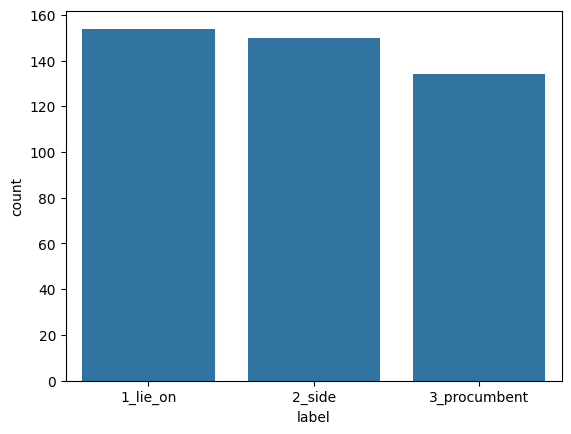

In [10]:
sns.countplot(x="label", data=train_df)

In [11]:
# Chuyển dữ liệu của label về dạng số
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["label"])

In [12]:
# Extract features
X_train = train_df.drop(columns="label")
y_train = train_df["label"]

In [13]:
X_train.head()

,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,left_eye_z,left_eye_outer_x,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,0.473795,-0.357386,-0.262433,0.485197,-0.386598,-0.241004,0.495594,-0.384288,-0.240937,0.506058,...,-0.056336,0.025932,0.446627,-0.073264,0.021940,0.556572,-0.166788,-0.051973,0.580216,-0.190334
1,0.014182,-0.378786,-0.340744,0.039380,-0.407932,-0.317016,0.053730,-0.404650,-0.316981,0.066587,...,0.079769,-0.036241,0.493168,0.049899,0.064985,0.527802,-0.046716,-0.088235,0.579529,-0.097076
2,-0.311832,0.049585,-0.618891,-0.359462,0.021462,-0.598566,-0.364006,0.000017,-0.598480,-0.368537,...,0.363640,0.674991,-0.160804,0.161039,0.520516,-0.262517,0.287587,0.802382,-0.192744,0.005253
3,0.134281,-0.177484,-0.151025,0.145981,-0.206998,-0.116603,0.155607,-0.203472,-0.116664,0.164882,...,-0.185648,-0.379976,0.532867,-0.233900,-0.383750,0.602609,-0.285776,-0.399479,0.575430,-0.380920
4,-0.022812,-0.221871,-0.204487,0.008552,-0.221771,-0.167069,0.028123,-0.211522,-0.166802,0.043752,...,-0.016234,0.000532,0.539949,-0.098527,0.179976,0.601646,-0.119508,-0.002799,0.648508,-0.203064


In [14]:
y_train

0      0
1      0
2      0
3      0
4      0
      ..
433    2
434    2
435    2
436    2
437    2
Name: label, Length: 438, dtype: int32

In [15]:
# Chuẩn hoá dữ liệu trên tập huấn luyện bằng z-scores
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [16]:
# X lúc này là một DataFrame mới với các cột mới được đánh số từ 0 đến n-1, trong đó n là số lượng cột trong dữ liệu ban đầu
X_train

array([[ 1.93555366, -1.12337517, -0.2264958 , ..., -0.17371318,
         1.12894804, -0.6673203 ],
       [ 0.11442174, -1.24162705, -0.57035406, ..., -0.26819719,
         1.1259225 , -0.46040318],
       [-1.17735063,  1.12541815, -1.79168718, ...,  2.0523683 ,
        -2.2783648 , -0.23335835],
       ...,
       [ 0.56496339, -0.51901027, -0.25500308, ..., -0.13473797,
         0.1671706 ,  1.22195221],
       [ 0.38492295, -0.86551308,  1.68849408, ..., -0.2475264 ,
         0.54007851, -0.08077349],
       [ 1.31624015, -1.08281963,  2.87906998, ...,  1.57898938,
         1.54951521, -0.67505219]])

In [17]:
import warnings
warnings.filterwarnings("ignore")

k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

In [18]:
def evaluate_model(name, model, results):
    # Đánh giá Model
    accuracy = cross_val_score(
        model, X_train, y_train, cv=k_fold, scoring="accuracy", n_jobs=-1, verbose=1
    ).mean()

    f1_score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring="f1_macro").mean()
    results.append((name, accuracy, f1_score))

In [19]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    ("SVC", SVC(probability=True, random_state=seed)),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
    ("RF", RandomForestClassifier(random_state=seed)),
    ("XGB", XGBClassifier(random_state=seed)),
]

models = {}
results_before_tunning = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model
    evaluate_model(name, model, results_before_tunning)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


In [20]:
def print_results(results):
    results.sort(key=lambda el: el[2], reverse=True)

    return pd.DataFrame(
        results,
        columns=[
            "Model",
            "Accuracy score",
            "F1 score",
        ],
    )

print_results(results_before_tunning)

,Model,Accuracy score,F1 score
0,SVC,0.890308,0.887826
1,XGB,0.872153,0.870876
2,RF,0.872153,0.870434
3,KNN,0.844645,0.838213
4,LR,0.805852,0.802673
5,DTC,0.801385,0.800225


<Axes: xlabel='F1 score', ylabel='Model'>

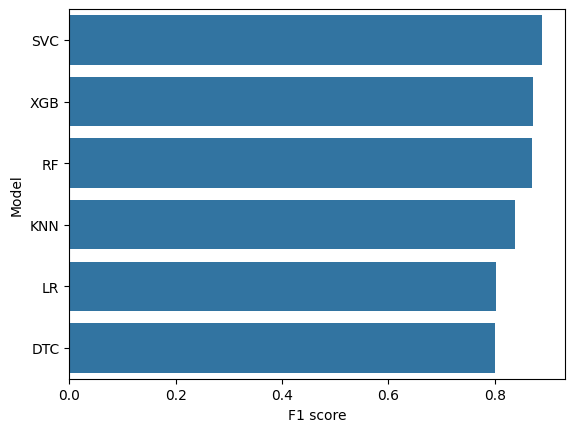

In [21]:
sns.barplot(x="F1 score", y="Model", data=print_results(results_before_tunning))

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict

In [23]:
y_pred = models['SVC'].predict(X_train)
cm_full_train = confusion_matrix(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)
cm_full_train, accuracy

(array([[151,   3,   0],
        [  3, 144,   3],
        [ 10,   2, 122]], dtype=int64),
 0.952054794520548)

In [24]:
svc_best_model = SVC(random_state=seed)

svc_best_model.fit(X_train, y_train)

SVC(random_state=42)

In [25]:
accuracy = cross_val_score(svc_best_model, X_train, y_train, cv=k_fold, scoring="accuracy").mean()
y_pred = cross_val_predict(svc_best_model, X_train, y_train, cv=k_fold)
cm_cross_val = confusion_matrix(y_train, y_pred)
accuracy, cm_cross_val

(0.8903082549634274,
 array([[145,   6,   3],
        [  7, 135,   8],
        [ 17,   7, 110]], dtype=int64))

<Axes: >

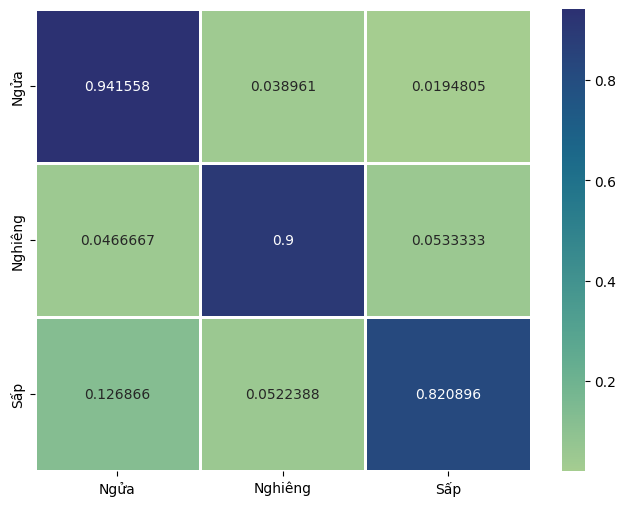

In [26]:
label_counts = np.sum(cm_cross_val, axis=1)
cm_cross_val = cm_cross_val / label_counts[:, None]
confusion_matrix_df = pd.DataFrame(cm_cross_val, index=["Ngửa", "Nghiêng", "Sấp"], columns=["Ngửa", "Nghiêng", "Sấp"])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, linewidths=1, annot=True, ax=ax, fmt="g", cmap="crest")